| <img src="./img/upv.png"> | <img src="./img/etsinf.png"> |


# Diseño y aplicación de técnicas metaheurísticas para el control de tráfico


### Universitat Politècnica de València


### Escola Tècnica Superior d’Enginyeria Informàtica


##### Grado en Ingeniería Informática


##### Trabajo Fin de Grado


2021 / 22

## Librerías

A contínuación se importan las librerías necesarias para la ejecución de todo el cuaderno

In [1]:
# Generales
import subprocess, shutil
import time
import random

# SUMO 
import traci
import sumolib
import randomTrips

# Python GUI
from tkinter import *
from tkinter import messagebox, filedialog

# Manipulacion de archivos .xml
import xml.etree.ElementTree as ET

# Visualización de datos
import matplotlib.pyplot as plt

## Definición

#### Definición del proyecto

<li> Nombre del proyecto </li>
<li> Duración de la simulación, en minutos </li>
<li> Número de vehículos en el escenario durante la simulación </li>

<li> Tipo de escenario </li>
<ul><li> Número de carriles, para la generación automática de escenarios  </li>
    <li> Velocidad máxima de los vehículos, en kilómetros / hora </li>
    <li> Velocidad máxima de las fases de los semáforos, en segundos </li>
    <li> Mapa de <i>OpenStreetMap</i> </li> </ul>

#### Definición del algoritmo genético

<li> Tamaño de la población </li>
<li> Número de iteraciones del algoritmo </li>
<li> Selección de los individuos </li>
<ul> <li> Equiprobable: todos los individuos con la misma probabilidad </li> 
     <li> Ponderada: la probabilidad de cada individuo es inversamente proporcional a la posición que ocupa, según su puntuación </li> </ul>
<li> Porcentaje de la población que se cruzarán dos a dos </li>
<ul> <li> Número de puntos de cruce </li> </ul>
<li> Porcentaje de la población que mutará genes aleatoriamente </li>
<ul> <li> Número de genes a mutar </li> </ul>
<li> Porcentaje de la población cuyos genes se crearán aleatoriamente </li>

## Interfaz gráfica

Selección / Introducción de datos

In [2]:
#  Interfaz grafica
def cont(*args):
    if not check_porcentajes():
        return
    if not check_calculos():
        return
    if not check_optimiza():
        return
    global nombre_proyecto, vehiculos, duracion, tipo_red, algoritmo
    nombre_proyecto = nom_proyecto.get()
    vehiculos = veh.get()
    duracion = 60 * d.get()
    tipo_red = t_red.get()
    algoritmo = alg_ruta.get()
    global calcula_lim_velocidad, calcula_fases_semaforos, optimiza_distancia, optimiza_tiempos, optimiza_limites_velocidad
    calcula_lim_velocidad = calc_lim_v.get()
    calcula_fases_semaforos = calc_fases.get()
    optimiza_distancia = opt_dist.get()
    optimiza_tiempos = opt_tiempo.get()
    optimiza_limites_velocidad = opt_lim_v.get()
    global velocidad_max, num_carriles, fase_max
    velocidad_max = round(v_max.get() / 3.6, 2)
    num_carriles = n_carriles.get()
    fase_max = t_fases.get()
    global calles_x, long_calles_x, calles_y, long_calles_y
    calles_x = n_x.get()
    long_calles_x = l_x.get()
    calles_y = n_y.get()
    long_calles_y = l_y.get()
    global calles_radial, calles_circular, dist_calles_circular
    calles_radial = n_r.get()
    calles_circular = n_c.get()
    dist_calles_circular = l_c.get()
    global num_intersecciones, long_calles_min, long_calles_max
    num_intersecciones = n_i.get()
    long_calles_min = l_min.get()
    long_calles_max = l_max.get()
    global tam_poblacion, iteraciones, seleccion, prob_cruce, num_ptos_cruce, prob_mutacion, num_mutaciones, prob_nuevo
    tam_poblacion = n_ind.get()
    iteraciones = n_itr.get()
    seleccion = sel.get()
    prob_cruce = p_cruce.get()
    num_ptos_cruce = n_cruce.get()
    prob_mutacion = p_muta.get()
    num_mutaciones = n_muta.get()
    prob_nuevo = p_nueva.get()
    global archivo_mapa
    archivo_mapa = archivo_osm.get()
    ventana.destroy()

def sig(*args):
    global ventana_1, ventana_2, ventana_3
    if ventana_3:
        cont()
    if ventana_2:
        datos_generales.grid_forget()
        sel_escenario.grid_forget()
        dt_alg_gen.grid(row=1, column=0, sticky=N, padx=5, pady=5)
        volver.grid(row=14, column=0, sticky=SE, padx=5, pady=5)
        continuar.config(text='Continuar ... ')
        ventana_1 = False
        ventana_2 = False
        ventana_3 = True
    if ventana_1:
        datos_generales.grid_forget()
        sel_escenario.grid(row=1, column=0, sticky=N, padx=5, pady=5)
        dt_alg_gen.grid_forget()
        volver.grid(row=14, column=0, sticky=SE, padx=5, pady=5)
        ventana_1 = False
        ventana_2 = True
        ventana_3 = False

def ant(*args):
    global ventana_1, ventana_2, ventana_3
    if ventana_2:
        datos_generales.grid(row=1, column=0, sticky=N, padx=5, pady=5)
        sel_escenario.grid_forget()
        dt_alg_gen.grid_forget()
        volver.grid_forget()
        ventana_1 = True
        ventana_2 = False
        ventana_3 = False
    if ventana_3:
        datos_generales.grid_forget()
        sel_escenario.grid(row=1, column=0, sticky=N, padx=5, pady=5)
        dt_alg_gen.grid_forget()
        volver.grid(row=14, column=0, sticky=SE, padx=5, pady=5)
        continuar.config(text='Siguiente   >>')
        ventana_1 = False
        ventana_2 = True
        ventana_3 = False

def funcion_red(*args):
    global tipo_red
    if t_red.get() == 'Manhattan':
        tipo_red = 'Manhattan'
        dt_escenario_012.grid(row=5, column=0, sticky=N, padx=5, pady=5)
        dt_escenario_0.grid(row=7, column=0, sticky=N, padx=5, pady=5)
        dt_escenario_1.grid_forget()
        dt_escenario_2.grid_forget()
        dt_escenario_3.grid_forget()
    elif t_red.get() == 'Spider':
        tipo_red = 'Spider'
        dt_escenario_012.grid(row=5, column=0, sticky=N, padx=5, pady=5)
        dt_escenario_0.grid_forget()
        dt_escenario_1.grid(row=7, column=0, sticky=N, padx=5, pady=5)
        dt_escenario_2.grid_forget()
        dt_escenario_3.grid_forget()
    elif t_red.get() == 'RandomNet':
        tipo_red = 'RandomNet'
        dt_escenario_012.grid(row=5, column=0, sticky=N, padx=5, pady=5)
        dt_escenario_0.grid_forget()
        dt_escenario_1.grid_forget()
        dt_escenario_2.grid(row=7, column=0, sticky=N, padx=5, pady=5)
        dt_escenario_3.grid_forget()
    elif t_red.get() == 'Real':
        tipo_red = 'Real'
        dt_escenario_012.grid_forget()
        dt_escenario_0.grid_forget()
        dt_escenario_1.grid_forget()
        dt_escenario_2.grid_forget()
        dt_escenario_3.grid(row=5, column=0, sticky=N, padx=5, pady=5)
    else:
        messagebox.showinfo(title='Error',
            message='Se ha producido un error en la selección')
    return True

def check_duracion(*args):
    if d.get() > 60:
        messagebox.showinfo(title='Atención',
            message='Valores elevados pueden ralentizar la ejecución')
    return True

def check_vehiculos(*args):
    if veh.get() > 2500:
        messagebox.showinfo(title='Atención',
            message='Valores elevados pueden ralentizar la ejecución')
    return True

def check_velocidad(*args):
    if int(v_max.get()) % 10 != 0:
        redondeo_v =round(int(v_max.get()), -1)
        entrada_vel.delete(0, END)
        entrada_vel.insert(0, redondeo_v)
        messagebox.showinfo(title='Atención',
            message='Se ha redonceado la velocidad a múltiplo de 10 km/h')
    return True

def check_calculos():
    if calc_lim_v.get(): 
        entrada_vel.config(state='normal')
        entrada_sel_optim_3.config(state='normal')
    else: entrada_vel.config(state='disabled')
    if calc_fases.get(): entrada_d_fases.config(state='normal')
    else: entrada_d_fases.config(state='disabled')
    if not calc_lim_v.get():
        entrada_sel_optim_3.config(state='disabled')
        if opt_lim_v.get():
            opt_lim_v.set(0)
            messagebox.showinfo(title='Atención',
                message='No se pueden optimizar los límites de velocidad\nsin incluirlos en los cálculos.')
    if (calc_lim_v.get() + calc_fases.get()) == 0:
        messagebox.showinfo(title='Atención',
            message='\nSe debe elegir al menos un elemento a emplear\nen los cálculos.\n\nSe debe seleccionar al menos una opción entre:\n\t> Límites de velocidad\n\t> Fases semafóricas')
        return False
    return True

def check_optimiza():  
    if opt_dist.get() + opt_tiempo.get() + opt_lim_v.get() == 0:
        messagebox.showinfo(title='Atención',
            message='\nSe debe elegir al menos un elemento a optimizar.\n\nSe debe seleccionar al menos una opción entre:\n\t> MAX: Distancia recorrida\n\t> MIN: Tiempos de viaje\n\t> MIN: Límite de velocidad')
        return False
    return True

def check_porcentajes(*args):
    if p_cruce.get() + p_muta.get() + p_nueva.get() > 100:
        messagebox.showinfo(title='Atención',
            message='\nRevise los porcentajes de selección de individuos\nantes de continuar.\nEl total excede el 100 %')
        return False
    if p_cruce.get() + p_muta.get() + p_nueva.get() < 100:
        messagebox.showinfo(title='Atención',
            message='\nRevise los porcentajes de selección de individuos\nantes de continuar.\nEl total no alcanza el 100 %')
        return False
    return True

def suma_porcentajes(*args):
    suma = p_cruce.get() + p_muta.get() + p_nueva.get()
    tot_porcentaje.config(text=str(suma))
    return True

def explorar_archivos():
    osm_map = filedialog.askopenfilename(initialdir = './data/',
                                            title = 'Selecione archivo de mapa:',
                                            filetypes = (("Archivo de OpenStreetMap", "*.osm*"), ("Todos los archivos", "*.*")),
                                            initialfile=('map.osm')
                                        )
    
    etiq_archivo_osm.config(text=str(osm_map))
    return archivo_osm.set(osm_map)

In [3]:
# GUI
ventana = Tk()

ventana.bind('<Return>', cont)

ventana_1 = True
ventana_2 = False
ventana_3 = False

nom_proyecto = StringVar(value='Simulacion')
veh = IntVar(value=250)
n_carriles = IntVar(value=2)
d = IntVar(value=10)
alg_ruta = StringVar(value='astar')
calc_lim_v = IntVar(value=1)
calc_fases = IntVar(value=1)
opt_dist = IntVar(value=1)
opt_tiempo = IntVar(value=1)
opt_lim_v = IntVar(value=1)

v_max = IntVar(value=50)
n_carriles = IntVar(value=2)
t_fases = IntVar(value=60)
t_red = StringVar(value='Manhattan')

n_x = IntVar(value=3)
l_x = DoubleVar(value=350.0)
n_y = IntVar(value=3)
l_y = DoubleVar(value=200.0)

n_r = IntVar(value=3)
n_c = IntVar(value=3)
l_c = DoubleVar(value=275.0)

n_i = IntVar(value=175)
l_min = DoubleVar(value=350.0)
l_max = DoubleVar(value=500.0)

n_ind = IntVar(value=200)
n_itr = IntVar(value=1250)

p_cruce = DoubleVar(value=60.0)
n_cruce = IntVar(value=2)
p_muta = DoubleVar(value=30.0)
n_muta = IntVar(value=10)
p_nueva = DoubleVar(value=10.0)
sel = StringVar(value='ponderada')

archivo_osm = StringVar(value='./data/map.osm')

ventana.title('Diseño y aplicación de técnicas metaheurísticas para el control de tráfico')
ventana.attributes('-topmost', True)
ventana.config(bd=15)

# Datos generales
datos_generales = Frame(ventana, highlightbackground="black", highlightthickness=0.5)
datos_generales.grid(row=1, column=0, sticky=N, padx=5, pady=5)

etiq_datos_generales = Label(datos_generales, text='DATOS GENERALES DE LA SIMULACIÓN')
etiq_datos_generales.config(font=('Arial',12,'bold'))
etiq_datos_generales.grid(row=0, column=0, columnspan=4, sticky=E+W, padx=5, pady=5)

datos = Frame(datos_generales)
datos.grid(row=1, column=0, sticky=E+W, padx=5, pady=5) 

etiq_titulo = Label(datos, text='Título para el proyecto: ')
etiq_titulo.grid(row=0, column=0, columnspan=2, sticky=E, padx=5, pady=5)
entrada_titulo = Entry(datos, textvariable=nom_proyecto)
entrada_titulo.grid(row=0, column=2, columnspan=2, sticky=W, padx=5, pady=5)

etiq_dur = Label(datos, text='Tiempo a simular (en minutos): ')
etiq_dur.grid(row=1, column=0, columnspan=2, sticky=E, padx=5, pady=5)
entrada_dur = Entry(datos, textvariable=d)
entrada_dur.config(validate='focusout', validatecommand=check_duracion)
entrada_dur.grid(row=1, column=2, columnspan=2, sticky=W, padx=5, pady=5)

etiq_n_veh = Label(datos, text='Nº de vehículos en el escenario: ')
etiq_n_veh.grid(row=2, column=0, columnspan=2, sticky=E, padx=5, pady=5)
entrada_n_veh = Entry(datos, textvariable=veh)
entrada_n_veh.config(validate='focusout', validatecommand=check_vehiculos)
entrada_n_veh.grid(row=2, column=2, columnspan=2, sticky=W, padx=5, pady=5)

etiq_sel_ind = Label(datos, text='Algoritmo para el cálculo de rutas: ')
etiq_sel_ind.grid(row=3, column=0, columnspan=2, sticky=E, padx=5, pady=5)
entrada_sel_ind_1 = Radiobutton(datos, text='Dijkstra', variable=alg_ruta, value='dijkstra')
entrada_sel_ind_1.grid(row=3, column=2, sticky=W, padx=5, pady=5)
entrada_sel_ind_2 = Radiobutton(datos, text='A*   (A estrella)', variable=alg_ruta, value='astar')
entrada_sel_ind_2.grid(row=3, column=3, sticky=W, padx=5, pady=5)

calculos = Frame(datos_generales, highlightbackground="black", highlightthickness=0.5)
calculos.grid(row=2, column=0, columnspan=2, sticky=N, padx=5, pady=5) 

etiq_sel_calc = Label(calculos, text='Incluir en los cálculos: ')
etiq_sel_calc.grid(row=0, column=0, sticky=E, padx=5, pady=5)
entrada_sel_calc_1 = Checkbutton(calculos, text='Límites de velocidad', variable=calc_lim_v, onvalue=1, offvalue=0, command=check_calculos)
entrada_sel_calc_1.grid(row=0, column=1, sticky=W, padx=5, pady=5)
entrada_sel_calc_2 = Checkbutton(calculos, text='Fases semafóricas', variable=calc_fases, onvalue=1, offvalue=0, command=check_calculos)
entrada_sel_calc_2.grid(row=1, column=1, sticky=W, padx=5, pady=5)

optimizaciones = Frame(datos_generales, highlightbackground="black", highlightthickness=0.5)
optimizaciones.grid(row=3, column=0, columnspan=2, sticky=N, padx=5, pady=5) 

etiq_sel_optim = Label(optimizaciones, text='Optimización: ')
etiq_sel_optim.grid(row=0, column=0, sticky=E, padx=5, pady=5)
entrada_sel_optim_1 = Checkbutton(optimizaciones, text='MAX: Distancia recorrida', variable=opt_dist, onvalue=1, offvalue=0, command=check_optimiza)
entrada_sel_optim_1.grid(row=0, column=1, sticky=W, padx=5, pady=5)
entrada_sel_optim_2 = Checkbutton(optimizaciones, text='MIN: Tiempos de viaje', variable=opt_tiempo, onvalue=1, offvalue=0, command=check_optimiza)
entrada_sel_optim_2.grid(row=1, column=1, sticky=W, padx=5, pady=5)
entrada_sel_optim_3 = Checkbutton(optimizaciones, text='MIN: Límite de velocidad', variable=opt_lim_v, onvalue=1, offvalue=0, command=check_optimiza)
entrada_sel_optim_3.grid(row=2, column=1, sticky=W, padx=5, pady=5)

sel_escenario = Frame(ventana, highlightbackground="black", highlightthickness=0.5)

t_escenario = Frame(sel_escenario, highlightbackground="black", highlightthickness=0.5)
t_escenario.grid(row=3, column=0, sticky=N, padx=5, pady=5)

etiq_escenario = Label(t_escenario, text='TIPO DE ESCENARIO')
etiq_escenario.config(font=('Arial',12,'bold'))
etiq_escenario.grid(row=0, column=0, columnspan=4, sticky=E+W, padx=5, pady=5)

etiq_sel_red = Label(t_escenario, text='Seleccione un tipo de red: ')
etiq_sel_red.grid(row=1, column=0, columnspan=4, sticky=E+W, padx=5, pady=5)

entrada_sel_red_1 = Radiobutton(t_escenario, text='Red mallada, tipo Manhattan', variable=t_red, value='Manhattan', command=funcion_red)
entrada_sel_red_1.grid(row=2, column=0, columnspan=2, sticky=E, padx=5, pady=5)
entrada_sel_red_2 = Radiobutton(t_escenario, text='Red radial, tipo tela de araña', variable=t_red, value='Spider', command=funcion_red)
entrada_sel_red_2.grid(row=3, column=0, columnspan=2, sticky=E, padx=5, pady=5)
entrada_sel_red_3 = Radiobutton(t_escenario, text='Red generada aleatoriamente', variable=t_red, value='RandomNet', command=funcion_red)
entrada_sel_red_3.grid(row=2, column=2, columnspan=2, sticky=W, padx=5, pady=5)
entrada_sel_red_4 = Radiobutton(t_escenario, text='Importar desde mapa de OpenStreetMaps', variable=t_red, value='Real', command=funcion_red)
entrada_sel_red_4.grid(row=3, column=2, columnspan=2, sticky=W, padx=5, pady=5)

dt_escenario_012 = Frame(sel_escenario, highlightbackground="black", highlightthickness=0.5)
dt_escenario_012.grid(row=5, column=0, sticky=N, padx=5, pady=5)

dt_escenario_0 = Frame(sel_escenario, highlightbackground="black", highlightthickness=0.5)
dt_escenario_0.grid(row=7, column=0, sticky=N, padx=5, pady=5)

dt_escenario_1 = Frame(sel_escenario, highlightbackground="black", highlightthickness=0.5)

dt_escenario_2 = Frame(sel_escenario, highlightbackground="black", highlightthickness=0.5)

dt_escenario_3 = Frame(sel_escenario, highlightbackground="black", highlightthickness=0.5)

# Redes generadas automaticamnte
etiq_dt_escenario = Label(dt_escenario_012, text='DATOS DEL ESCENARIO')
etiq_dt_escenario.config(font=('Arial',12,'bold'))
etiq_dt_escenario.grid(row=0, column=0, columnspan=4, sticky=E+W, padx=5, pady=5)

etiq_vel = Label(dt_escenario_012, text='Introduzca la velocidad máxima (en múltiplos de 10 km/h): ')
etiq_vel.grid(row=1, column=0, columnspan=2, sticky=E+W, padx=5, pady=5)
entrada_vel = Entry(dt_escenario_012, textvariable=v_max)
entrada_vel.config(validate='focusout', validatecommand=check_velocidad)
entrada_vel.grid(row=1, column=2, sticky=E+W, padx=5, pady=5)
etiq_kmh = Label(dt_escenario_012, text=' km/h')
etiq_kmh.grid(row=1, column=3, sticky=E+W, padx=5, pady=5)

etiq_n_carriles = Label(dt_escenario_012, text='Nº de carriles por cada sentido de circulación: ')
etiq_n_carriles.grid(row=2, column=1, sticky=E+W, padx=5, pady=5)
entrada_n_carriles = Entry(dt_escenario_012, textvariable=n_carriles)
entrada_n_carriles.grid(row=2, column=2, sticky=E+W, padx=5, pady=5)
etiq_carriles = Label(dt_escenario_012, text=' carril/es')
etiq_carriles.grid(row=2, column=3, sticky=E+W, padx=5, pady=5)

etiq_d_fases = Label(dt_escenario_012, text='Duración máxima de las fases del semáforo: ')
etiq_d_fases.grid(row=3, column=1, sticky=E+W, padx=5, pady=5)
entrada_d_fases = Entry(dt_escenario_012, textvariable=t_fases)
entrada_d_fases.grid(row=3, column=2, sticky=E+W, padx=5, pady=5)
etiq_fases = Label(dt_escenario_012, text=' segundos')
etiq_fases.grid(row=3, column=3, sticky=E+W, padx=5, pady=5)

# Red mallada
etiq_dt_escenario = Label(dt_escenario_0, text='DATOS DE LA RED MALLADA')
etiq_dt_escenario.config(font=('Arial',12,'bold'))
etiq_dt_escenario.grid(row=0, column=0, columnspan=4, sticky=E+W, padx=5, pady=5)

etiq_n_calles_x = Label(dt_escenario_0, text='Nº de calles en horizontal: ')
etiq_n_calles_x.grid(row=1, column=0, sticky=E+W, padx=5, pady=5)
entrada_etiq_n_calles_x = Entry(dt_escenario_0, textvariable=n_x)
entrada_etiq_n_calles_x.grid(row=1, column=1, sticky=E+W, padx=5, pady=5)

etiq_lon_calles_x = Label(dt_escenario_0, text='Distancia entre calles en horizontal: ')
etiq_lon_calles_x.grid(row=1, column=2, sticky=E+W, padx=5, pady=5)
entrada_etiq_lon_calles_x = Entry(dt_escenario_0, textvariable=l_x)
entrada_etiq_lon_calles_x.grid(row=1, column=3, sticky=E+W, padx=5, pady=5)

etiq_n_calles_y = Label(dt_escenario_0, text='Nº de calles en vertical: ')
etiq_n_calles_y.grid(row=2, column=0, sticky=E+W, padx=5, pady=5)
entrada_etiq_n_calles_y = Entry(dt_escenario_0, textvariable=n_y)
entrada_etiq_n_calles_y.grid(row=2, column=1, sticky=E+W, padx=5, pady=5)

etiq_lon_calles_y= Label(dt_escenario_0, text='Distancia entre calles en vertical: ')
etiq_lon_calles_y.grid(row=2, column=2, sticky=E+W, padx=5, pady=5)
entrada_etiq_lon_calles_y = Entry(dt_escenario_0, textvariable=l_y)
entrada_etiq_lon_calles_y.grid(row=2, column=3, sticky=E+W, padx=5, pady=5)

# Red tela de araña
etiq_dt_escenario = Label(dt_escenario_1, text='DATOS DE LA RED RADIAL')
etiq_dt_escenario.config(font=('Arial',12,'bold'))
etiq_dt_escenario.grid(row=0, column=0, columnspan=4, sticky=E+W, padx=5, pady=5)

etiq_n_calles_r = Label(dt_escenario_1, text='Nº de calles radiales: ')
etiq_n_calles_r.grid(row=1, column=0, sticky=E+W, padx=5, pady=5)
entrada_etiq_n_calles_r = Entry(dt_escenario_1, textvariable=n_r)
entrada_etiq_n_calles_r.grid(row=1, column=1, sticky=E+W, padx=5, pady=5)

etiq_n_calles_c = Label(dt_escenario_1, text='Nº de calles concéntricas: ')
etiq_n_calles_c.grid(row=2, column=0, sticky=E+W, padx=5, pady=5)
entrada_etiq_n_calles_c = Entry(dt_escenario_1, textvariable=n_c)
entrada_etiq_n_calles_c.grid(row=2, column=1, sticky=E+W, padx=5, pady=5)

etiq_lon_calles_c= Label(dt_escenario_1, text='Distancia entre calles concéntricas: ')
etiq_lon_calles_c.grid(row=2, column=2, sticky=E+W, padx=5, pady=5)
entrada_etiq_lon_calles_c = Entry(dt_escenario_1, textvariable=l_c)
entrada_etiq_lon_calles_c.grid(row=2, column=3, sticky=E+W, padx=5, pady=5)

# Red aleatoria
etiq_dt_escenario = Label(dt_escenario_2, text='DATOS DE LA RED ALEATORIA')
etiq_dt_escenario.config(font=('Arial',12,'bold'))
etiq_dt_escenario.grid(row=0, column=0, columnspan=4, sticky=E+W, padx=5, pady=5)

etiq_n_intersc = Label(dt_escenario_2, text='Nº de intersecciones: ')
etiq_n_intersc.grid(row=1, column=0, sticky=E+W, padx=5, pady=5)
entrada_n_intersc = Entry(dt_escenario_2, textvariable=n_i)
entrada_n_intersc.grid(row=1, column=1, sticky=E+W, padx=5, pady=5)

etiq_lon_calles_x = Label(dt_escenario_2, text='Distancia mínima entre intersecciones: ')
etiq_lon_calles_x.grid(row=1, column=2, sticky=E+W, padx=5, pady=5)
entrada_etiq_lon_calles_x = Entry(dt_escenario_2, textvariable=l_min)
entrada_etiq_lon_calles_x.grid(row=1, column=3, sticky=E+W, padx=5, pady=5)

etiq_lon_calles_y= Label(dt_escenario_2, text='Distancia máxima entre intersecciones: ')
etiq_lon_calles_y.grid(row=2, column=2, sticky=E+W, padx=5, pady=5)
entrada_etiq_lon_calles_y = Entry(dt_escenario_2, textvariable=l_max)
entrada_etiq_lon_calles_y.grid(row=2, column=3, sticky=E+W, padx=5, pady=5)

# Archivo de OpenStreetMap
etiq_dt_escenario = Label(dt_escenario_3, text='OPEN STREET MAP')
etiq_dt_escenario.config(font=('Arial',12,'bold'))
etiq_dt_escenario.grid(row=0, column=0, columnspan=4, sticky=E+W, padx=5, pady=5)

mapa = Button(dt_escenario_3, text='Seleccionar archivo de mapa de OpenStreetMap...', command=explorar_archivos)
mapa.grid(row=1, column=0, columnspan=4, sticky=E+W, padx=5, pady=5)

etiq_osm= Label(dt_escenario_3, text='Archivo:       ')
etiq_osm.grid(row=2, column=0, sticky=E, padx=5, pady=5)

etiq_archivo_osm = Label(dt_escenario_3, text=archivo_osm.get())
etiq_archivo_osm.grid(row=2, column=1, columnspan=3, sticky=W, padx=5, pady=5)

# Algoritmo genetico
dt_alg_gen = Frame(ventana, highlightbackground="black", highlightthickness=0.5)

etiq_dt_escenario = Label(dt_alg_gen, text='DATOS DEL ALGORITMO GENÉTICO')
etiq_dt_escenario.config(font=('Arial',12,'bold'))
etiq_dt_escenario.grid(row=0, column=0, columnspan=4, sticky=E+W, padx=5, pady=5)

etiq_n_ind = Label(dt_alg_gen, text='Introduzca el tamaño de la población: ')
etiq_n_ind.grid(row=1, column=0, columnspan=2, sticky=E, padx=5, pady=5)
entrada_n_ind = Entry(dt_alg_gen, textvariable=n_ind)
entrada_n_ind.grid(row=1, column=2, columnspan=2, sticky=W, padx=5, pady=5)

etiq_n_itr = Label(dt_alg_gen, text='Introduzca el número de iteraciones: ')
etiq_n_itr.grid(row=2, column=0, columnspan=2, sticky=E, padx=5, pady=5)
entrada_n_itr = Entry(dt_alg_gen, textvariable=n_itr)
entrada_n_itr.grid(row=2, column=2, columnspan=2, sticky=W, padx=5, pady=5)

etiq_n_itr_info = Label(dt_alg_gen, text=f'Se efectuarán, al menos, un número de iteraciones igual a\ndos veces el valor del tamaño de la población desde la obtención del mejor individuo')
etiq_n_itr_info.grid(row=3, column=0, columnspan=4, sticky=E+W, padx=5, pady=5)

etiq_sel_ind = Label(dt_alg_gen, text='Indique el modo de selección de los individuos: ')
etiq_sel_ind.grid(row=4, column=0, columnspan=2, sticky=E, padx=5, pady=5)
entrada_sel_ind_1 = Radiobutton(dt_alg_gen, text='Equiprobable', variable=sel, value='equiprobable')
entrada_sel_ind_1.grid(row=4, column=2, sticky=W, padx=5, pady=5)
entrada_sel_ind_2 = Radiobutton(dt_alg_gen, text='Ponderada', variable=sel, value='ponderada')
entrada_sel_ind_2.grid(row=4, column=3, sticky=W, padx=5, pady=5)

etiq_pob_info = Label(dt_alg_gen, text='En cada iteración:')
etiq_pob_info.grid(row=6, column=0, columnspan=4, sticky=E+W, padx=5, pady=5)

etiq_pob_cruce = Label(dt_alg_gen, text='% de probabilidad de creación individuos a través de CRUCE: ')
etiq_pob_cruce.grid(row=8, column=0, sticky=E, padx=5, pady=5)
entrada_etiq_pob_cruce = Entry(dt_alg_gen, textvariable=p_cruce)
entrada_etiq_pob_cruce.config(validate='all', validatecommand=suma_porcentajes)
entrada_etiq_pob_cruce.grid(row=8, column=1, sticky=W, padx=5, pady=5)

etiq_n_cruce = Label(dt_alg_gen, text='Puntos de cruce: ')
etiq_n_cruce.grid(row=8, column=2, sticky=E, padx=5, pady=5)
entrada_etiq_n_cruce = Entry(dt_alg_gen, textvariable=n_cruce)
entrada_etiq_n_cruce.grid(row=8, column=3, sticky=W, padx=5, pady=5)

etiq_pob_muta = Label(dt_alg_gen, text='% de probabilidad de creación individuos a través de MUTACIÓN: ')
etiq_pob_muta.grid(row=9, column=0, sticky=E, padx=5, pady=5)
entrada_etiq_pob_muta = Entry(dt_alg_gen, textvariable=p_muta)
entrada_etiq_pob_muta.config(validate='all', validatecommand=suma_porcentajes)
entrada_etiq_pob_muta.grid(row=9, column=1, sticky=W, padx=5, pady=5)

etiq_n_muta = Label(dt_alg_gen, text='Nº de genes a mutar: ')
etiq_n_muta.grid(row=9, column=2, sticky=E, padx=5, pady=5)
entrada_etiq_n_muta = Entry(dt_alg_gen, textvariable=n_muta)
entrada_etiq_n_muta.grid(row=9, column=3, sticky=W, padx=5, pady=5)

etiq_pob_nueva = Label(dt_alg_gen, text='% de probabilidad de creación de un NUEVO individuo de forma aleatoria: ')
etiq_pob_nueva.grid(row=10, column=0, sticky=E, padx=5, pady=5)
entrada_etiq_pob_nueva = Entry(dt_alg_gen, textvariable=p_nueva)
entrada_etiq_pob_nueva.config(validate='all', validatecommand=suma_porcentajes)
entrada_etiq_pob_nueva.grid(row=10, column=1, sticky=W, padx=5, pady=5)

etiq_tot_porcentaje = Label(dt_alg_gen, text='Suma total (%): ')
etiq_tot_porcentaje.grid(row=11, column=0, sticky=E, padx=5, pady=5)
tot_porcentaje = Label(dt_alg_gen, text='100.0')
tot_porcentaje.grid(row=11, column=1, sticky=W, padx=5, pady=5)

# Continuar la ejecucion
volver = Button(ventana, text=' <<   Anterior', command=ant, font=('Arial',12,'bold'))

continuar = Button(ventana, text='Siguiente   >>', command=sig, font=('Arial',12,'bold'))
continuar.grid(row=14, column=1, sticky=SE, padx=5, pady=5)

# Variables si se cierra la ventana con [X]
nombre_proyecto = nom_proyecto.get()
vehiculos = veh.get()
duracion = 60 * d.get()
velocidad_max = round(3.6 * v_max.get(), 2)
algoritmo = alg_ruta.get()
calcula_lim_velocidad = calc_lim_v.get()
calcula_fases_semaforos = calc_fases.get()
optimiza_distancia = opt_dist.get()
optimiza_tiempos = opt_tiempo.get()
tipo_red = t_red.get()
num_carriles = n_carriles.get()
fase_max = t_fases.get()
calles_x = n_x.get()
long_calles_x = l_x.get()
calles_y = n_y.get()
long_calles_y = l_y.get()
calles_radial = n_r.get()
calles_circular = n_c.get()
dist_calles_circular = l_c.get()
num_intersecciones = n_i.get()
long_calles_min = l_min.get()
long_calles_max = l_max.get()
tam_poblacion = n_ind.get()
iteraciones = n_itr.get()
seleccion = sel.get()
prob_cruce = p_cruce.get()
num_ptos_cruce = n_cruce.get()
prob_mutacion = p_muta.get()
num_mutaciones = n_muta.get()
prob_nuevo = p_nueva.get()
archivo_mapa = archivo_osm.get()

ventana.mainloop()

## Funciones para el algoritmo genético

#### Función de cruce

Dadas 2 listas y un número <b><i>n</i></b> de puntos de corte, se realizará un cruce entre ambas listas

<img src="./img/cruce.png"> 

In [4]:
def cruce(lista1, lista2, n):
    hijo1 = []
    hijo2 = []
    
    pos_cruces = [0, len(lista1)] + [random.randint(1, len(lista1) - 1) for x in range(n)]
    pos_cruces.sort()

    for i in range(1, len(pos_cruces)):
        if i % 2:
            hijo1.extend(lista1[pos_cruces[i - 1]:pos_cruces[i]])
            hijo2.extend(lista2[pos_cruces[i - 1]:pos_cruces[i]])
        else:
            hijo1.extend(lista2[pos_cruces[i - 1]:pos_cruces[i]])
            hijo2.extend(lista1[pos_cruces[i - 1]:pos_cruces[i]])
    
    return [hijo1, hijo2]

#### Función de mutación

Dada una lista y un número <b><i>n</i></b> de mutaciones, se realizarán este número de cambios entre un valor mínimo y máximo (ambos incluidos).

<img src="./img/mutacion.png">

Los genes que pueden mutar en cada individuo se limitan a un máximo del 25%.

In [5]:
def mutacion(lista, minimo, maximo, multiplo, n):
    hijo = lista
    n = min(n, round(0.25 * len(lista)))
    
    pos_cruces = [random.randint(1, len(lista) - 1) for x in range(n)]

    for i in pos_cruces: 
        hijo[i] = round(minimo + multiplo * random.randint(0, round((maximo - minimo) / multiplo)), 2)
    
    return hijo

#### Función fitness

Se valorará en cada solución: 
<li> <b>MAXIMIZAR</b> la distancia media de los trayectos respecto de la distancia media en la solución base </li>

$$ D = \frac{d_{media_{SOLUCIÓN}}} {d_{media_{BASE}}} $$ 

Será mayor cuanto mayor sea la distancia media recorrida en la solución.

<li> <b>MINIMIZAR</b> los tiempos medios efectivos de viaje respecto de estos mismos tiempos de la solución base, y los tiempos perdidos </li>

$$  T = 0.5 * \frac {t_{efectivo_{BASE}}} {t_{efectivo_{SOLUCIÓN}}} + 0.5 * \frac {t_{perdido_{BASE}}} {t_{perdido_{SOLUCIÓN}}} $$

en donde los tiempos medios efectivos serán igual a la duración media de los trayectos menos los tiempos perdidos:

$$ t_{efectivo} = t_{total} - t_{perdido} $$

Será mayor cuanto menores sean los tiempos efectivos de viaje y los tiempos perdidos en la solución.

<li> <b>MINIMIZAR</b> la suma de límistes de velocidad de cada calle respecto de estos mismos límites de la solución base </li>

$$ V = \frac {\sum {Limite_{velocidad_{BASE}}}} {\sum {Limite_{velocidad_{SOLUCIÓN}}}} $$

Será mayor cuanto menores sean los límites de velocidad de la solución.

<li> Según las opciones elegidas a optimizar: </li> 
<ul><li> Si se selecciona, a las distancias asignaremos un peso del 70%, a los tiempos (efectivos y perdidos) asignaremos el 10% y a los límites de velocidad de las calles el 20%, de tal forma que: </li></ul>

$$ \alpha = 7.0 \;\;\;,\;\;\; \beta = 1.0 \;\;\;,\;\;\; \gamma = 2.0 $$

<ul><li> Con unos coeficientes a cada sumando de: </li></ul>

$$ \frac {\alpha} {\alpha + \beta + \gamma} \;\;\;,\;\;\; \frac {\beta} {\alpha + \beta + \gamma} \;\;\;,\;\;\; \frac {\gamma} {\alpha + \beta + \gamma} $$

<center> respectivamente. </center>

<ul><li> Aquella que no se seleccione tendrá un valor nulo </li></ul>

<li> Por tanto, sumando cada una de las valoraciones: </li>

$$ fitness = \frac {100} {\alpha + \beta + \gamma} * \left( \alpha * D + \beta * T + \gamma * V \right) $$

Desglosando:

$$ fitness = \frac {100} {\alpha + \beta + \gamma} * \left[ \alpha * \frac{d_{media_{SOLUCIÓN}}} {d_{media_{BASE}}} + \beta * \left( 0.5 * \frac {t_{efectivo_{BASE}}} {t_{efectivo_{SOLUCIÓN}}} + 0.5 * \frac {t_{perdido_{BASE}}} {t_{perdido_{SOLUCIÓN}}} \right) + \gamma * \frac {\sum {Lim_{vel_{BASE}}}} {\sum {Lim_{vel_{SOLUCIÓN}}}} \right] $$

In [6]:
def fitness(vel_base, vel_test, archivo_base_xml, archivo_test_xml):
    ftnss = 0.0
    alfa, beta, gamma = 0.0, 0.0, 0.0
    
    base = ET.parse(archivo_base_xml)
    raiz_base = base.getroot()

    test = ET.parse(archivo_test_xml)
    raiz_test = test.getroot()
    
    if optimiza_distancia:
        dist_base = float(raiz_base.find('vehicleTripStatistics').get('routeLength'))
        dist_test = float(raiz_test.find('vehicleTripStatistics').get('routeLength'))
        alfa = 7.0
        ftnss += alfa * (dist_test / dist_base)
    
    if optimiza_tiempos:
        t_total_base = float(raiz_base.find('vehicleTripStatistics').get('duration'))
        t_perdido_base = float(raiz_base.find('vehicleTripStatistics').get('timeLoss'))
        t_efectivo_base = t_total_base - t_perdido_base
        t_total_test = float(raiz_test.find('vehicleTripStatistics').get('duration'))
        t_perdido_test = float(raiz_test.find('vehicleTripStatistics').get('timeLoss'))
        t_efectivo_test = t_total_test - t_perdido_test
        beta = 1.0
        ftnss += beta * (0.5 * (t_efectivo_base / t_efectivo_test) + 0.5 * (t_perdido_base / t_perdido_test))

    if optimiza_limites_velocidad:
        gamma = 2.0
        ftnss += gamma * (vel_base / vel_test)

    return (100.0 / (alfa + beta + gamma)) * ftnss

#### Generación de lista de números aleatorios

Genera una lista de <b><i>n</i></b> números aleatorios, cuyos valores serán <b><i>múltiplos</i></b> a uno dado, entre un valor mínimo y máximo (ambos incluidos).

In [7]:
def genera_lista(n = 1, minimo = 2.78, maximo = 13.90, multiplo = 2.78):
    if maximo < minimo:
        minimo, maximo = maximo, minimo
    return [round((minimo + multiplo * random.randint(0, round((maximo - minimo) / multiplo))), 2) for _ in range(n)]

#### Codificación del escenario

Dados un identificador y los datos de un escenario en un archivo <b><i>xml</i></b>, obtendremos un individuo. Este individuo codificado será empleado por el algorítmo genético

En un diccionario se almacenan las cantidades o índices de datos a codificar y decodificar, en los cáclulos del algoritmo y las simulaciones:
A partir del archivo <b><i>xml</i></b> del escenario, codificamos la solucion con el valor de cada parámtro de cada elemento:
<li> <b>Id</b>: identificador de la solución. Para la solución base <i>(con los parámetros por defecto)</i>: <b><i>id = 0</i></b> </li>
<li> <b>Puntuación</b>: valor de la función fitness para la solución. Sin evaluar, será igual a <b><i>puntuación = - ∞</i></b> </li>
<li> <b>Calles</b>: lista con los limites de velocidad de cada calle</li>
<li> <b>Intersecciones</b>: tiempos de fases en cada ciclo <i>(excepto fases en ámbar)</i> </li>

In [8]:
def codificador(id, ruta_archivo_net_xml):
    individuo = {
        'id' : id,
        'puntuacion' : - float('inf')
    }
    if calcula_lim_velocidad:
        individuo['v_calles'] = []
    if calcula_fases_semaforos:
        individuo['intersecciones'] = []

    arbol = ET.parse(ruta_archivo_net_xml)
    raiz = arbol.getroot()

    if calcula_lim_velocidad:
        for calle in raiz.findall('edge'):
            if calle.get('id')[0] == ':':
                continue
            lim_velocidad = calle.find('lane').get('speed')
            individuo['v_calles'].append(float(lim_velocidad))

    if calcula_fases_semaforos:
        for semaforo in raiz.findall('tlLogic'):
            for fase in semaforo.findall('phase'):
                estado = fase.get('state')
                if 'y' not in estado:
                    individuo['intersecciones'].append(int(fase.get('duration')))

    return individuo

#### Decodificación del individuo

Dados los datos codificados de un <b><i>individuo</b></i> y los datos de un escenario en un archivo <b><i>xml</i></b> a editar, obtendremos el escenario <b><i>xml</i></b> correspondiente que será simulado y evaluado

De los datos codificados estableceremos:
<li> <b>Calles</b>: lista con los limites de velocidad de cada calle</li>
<li> <b>Intersecciones</b>: tiempos de fases en cada ciclo <i>(excepto fases en ámbar)</i> </li>

In [9]:
def decodificador(individuo, ruta_archivo_net_xml):
    arbol = ET.parse(ruta_archivo_net_xml)
    raiz = arbol.getroot()
   
    if calcula_lim_velocidad:
        n_calles = 0
        for calle in raiz.findall('edge'):
            if calle.get('id')[0] == ':':
                continue
            for carril in calle.findall('lane'):
                carril.set('speed', str(individuo['v_calles'][n_calles]))
            n_calles += 1

    if calcula_fases_semaforos:
        n_fase = 0
        for semaforo in raiz.findall('tlLogic'):
            for fase in semaforo.findall('phase'):
                estado = fase.get('state')
                if 'y' not in estado:
                    fase.set('duration', str(individuo['intersecciones'][n_fase]))
                    n_fase += 1

    arbol = ET.ElementTree(raiz)

    try:
        arbol.write(open(ruta_archivo_net_xml,'w'), encoding='unicode')
    except PermissionError:
        print("Error al escribir el archivo .net.xml")
    finally:
        pass

    return individuo

#### Simuación y evaluación de cada individuo

Para cada individuo a evaluar, se decodificará, simulará y puntuará según la función fitness

Para cada solución que mejore a todas las anteriores, se guardará su identificador (que coincidirá con el ordinal de su creación) y su puntuación, para poder observar posteriromente la evolución del algoritmo: generación de soluciones y mejora de sus valoraciones

Del individuo con mejor puntuación, se guardará también una copia del escenario y de los datos estadísticos de la simulación, para poder replicarla

In [10]:
poblacion = []

id_puntuacion_max = []
puntuacion_max = []

In [11]:
def evalua(sol):
    decodificador(sol, './data/' + nombre_proyecto + '.test.net.xml')

    traci.start([sumolib.checkBinary('sumo'), '-c', './data/' + nombre_proyecto + '.test.sumocfg',
        '--tripinfo-output', './data/' + nombre_proyecto + '.test.tripInfo.xml',
        '--tripinfo-output.write-unfinished', 'true',
        '--statistic-output', './data/' + nombre_proyecto + '.test.tripStats.xml'
    ])

    traci.simulation.step(duracion)

    traci.close()

    if calcula_lim_velocidad == 0:
        sol['v_calles'] = [1]

    puntos = fitness(sum(sol_base['v_calles']), sum(sol['v_calles']),'./data/' + nombre_proyecto + '.tripStats.xml', './data/' + nombre_proyecto + '.test.tripStats.xml')
    sol['puntuacion'] = puntos

    if len(puntuacion_max) == 0:
        id_puntuacion_max.append(sol['id'])
        puntuacion_max.append(puntos)

    if puntos > puntuacion_max[-1]:
        id_puntuacion_max.append(sol['id'])
        puntuacion_max.append(puntos)
        
        shutil.copy('./data/' + nombre_proyecto + '.test.net.xml',
            './data/' + nombre_proyecto + '.BEST.net.xml')
        shutil.copy('./data/' + nombre_proyecto + '.test.tripStats.xml',
            './data/' + nombre_proyecto + '.BEST.tripStats.xml')

## Tipos de escenarios

#### Red tipo Manhattan

<img src="./img/manhattan.png">

In [12]:
if tipo_red == 'Manhattan':

    cmd_manhattan = ['netgenerate', 
        '--grid',
        '--grid.x-number', str(calles_x),
        '--grid.x-length', str(long_calles_x),
        '--grid.y-number', str(calles_y),
        '--grid.y-length', str(long_calles_y),
        '--default.lanenumber', str(num_carriles),
        '--default.speed', str(velocidad_max),
        '--no-turnarounds', 'true',
        '--default-junction-type', 'traffic_light',
        '--no-turnarounds.tls', 'true',
        '--tls.guess', 'true',
        '--output-file', './data/' + nombre_proyecto + '.net.xml'
    ]

    subprocess.run(cmd_manhattan)

#### Red tipo tela de araña

<img src="./img/aranya.png">

In [13]:
if tipo_red == 'Spider':

    cmd_aranya = ['netgenerate', 
        '--spider',
        '--spider.arm-number', str(calles_radial),
        '--spider.circle-number', str(calles_circular),
        '--spider.space-radius', str(dist_calles_circular),
        '--default.lanenumber', str(num_carriles),
        '--default.speed', str(velocidad_max),
        '--no-turnarounds', 'true',
        '--default-junction-type', 'traffic_light',
        '--no-turnarounds.tls', 'true',
        '--tls.guess', 'true',
        '--output-file', './data/' + nombre_proyecto + '.net.xml'
    ]

    subprocess.run(cmd_aranya)

#### Red tipo aleatoria

<img src="./img/aleatoria.png">

In [14]:
if tipo_red == 'RandomNet':

    cmd_aleatoria = ['netgenerate', 
        '--rand',
        '--rand.iterations', str(num_intersecciones),
        '--rand.min-distance', str(long_calles_min),
        '--rand.max-distance', str(long_calles_max),
        '--default.lanenumber', str(num_carriles),
        '--default.speed', str(velocidad_max),
        '--rand.random-lanenumber', 'true',
        '--no-turnarounds', 'true',
        '--default-junction-type', 'traffic_light',
        '--no-turnarounds.tls', 'true',
        '--tls.guess', 'true',
        '--output-file', './data/' + nombre_proyecto + '.net.xml'
    ]

    subprocess.run(cmd_aleatoria)

#### Escenario real

<img src="./img/zamora.png">

In [15]:
if tipo_red == 'Real':
    cmd_mapa = ['netconvert',
        '--osm-files', archivo_mapa,
        '--geometry.remove', 'true',
        '--junctions.join', 'true',
        '--tls.guess-signals', 'true',
        '--tls.discard-simple', 'true',
        '--tls.join', 'true',
        '--tls.default-type', 'actuated',
        '--tls.min-dur', '3',
        '--tls.max-dur', str(fase_max),
        '--no-turnarounds', 'true',
        '--no-turnarounds.tls', 'true',
        '--tls.guess', 'true',
        '--output-file', './data/' + nombre_proyecto + '.net.xml'
    ]
    
    subprocess.run(cmd_mapa)

## Generación de rutas

Generación de rutas aleatorias para el escenario, según el número de vehículos y el tiempo a simular indicados.
Las rutas se calcularán con uno de estos algoritmos:
<li> <b>Dijkstra</b>: dijkstra </li>
<li> <b>A*</b>: astar </li>

In [16]:
randomTrips.main(randomTrips.get_options([ 
    '--net-file', './data/' + nombre_proyecto + '.net.xml',
    '--begin', '0',
    '--end', '1',
    '--period', '1',
    '--flows', str(2 * vehiculos),
    '--output-trip-file', './data/' + nombre_proyecto + '.trips.xml'
    ]
))

algoritmo = random.choice(['astar', 'dijkstra'])
print("Algoritmo para el cálculo de rutas: ", algoritmo)

Algoritmo para el cálculo de rutas:  astar


In [17]:
cmd_rutas = ['duarouter', 
    '--net-file', './data/' + nombre_proyecto + '.net.xml',
    '--route-files', './data/' + nombre_proyecto + '.trips.xml',
    '--begin', '0',
    '--end', str(duracion),
    '--route-steps', str(duracion),
    '--routing-algorithm', str(algoritmo),
    '--output-file', './data/' + nombre_proyecto + '.rou.xml'
    ]

subprocess.run(cmd_rutas)

CompletedProcess(args=['duarouter', '--net-file', './data/Simulacion.net.xml', '--route-files', './data/Simulacion.trips.xml', '--begin', '0', '--end', '600', '--route-steps', '600', '--routing-algorithm', 'astar', '--output-file', './data/Simulacion.rou.xml'], returncode=0)

In [18]:
cmd_rutas_cont = ['generateContinuousRerouters.py',
    '--end', str(duracion),
    '-n', './data/' + nombre_proyecto + '.net.xml',
    '-o', './data/' + nombre_proyecto + '.contRou.xml'
]

subprocess.run(cmd_rutas_cont, shell=True)

CompletedProcess(args=['generateContinuousRerouters.py', '--end', '600', '-n', './data/Simulacion.net.xml', '-o', './data/Simulacion.contRou.xml'], returncode=0)

## Archivos de configuración

#### Generación de archivo de configuración de la simulación base

Generación del archivo de configuración <b><i>sumocfg</i></b> para realizar la simulación con los datos por defecto del escenario

In [19]:
configuracion = '''<?xml version="1.0" encoding="iso-8859-1"?>

<configuration xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.sf.net/xsd/sumoConfiguration.xsd">

    <input>
        <net-file value=""/>
        <route-files value=""/>
		<additional-files value=""/>
    </input>

    <time>
        <begin value="0"/>
        <end value=""/>
    </time>

</configuration>
'''

raiz = ET.fromstring(configuracion)

entrada = raiz.find('input')

red = entrada.find('net-file')
red.set('value', str(nombre_proyecto + '.net.xml'))

rutas = entrada.find('route-files')
rutas.set('value', str(nombre_proyecto + '.rou.xml'))

rutas_cont = entrada.find('additional-files')
rutas_cont.set('value', str(nombre_proyecto + '.contRou.xml'))

tiempos = raiz.find('time')

t_fin = tiempos.find('end')
t_fin.set('value', str(duracion))

arbol = ET.ElementTree(raiz)
arbol.write(open('./data/' + nombre_proyecto + '.sumocfg','w'), encoding='unicode')

# ET.dump(raiz)

#### Generación de los archivo de configuración y de escenario

Copia del archivo de configuración <b><i>sumocfg</i></b> para realizar las simulaciones con los individuos de la población. 

El escenario y las rutas serán las mismas para que los resultados sean comparables. 
Unicamente se modificarán los datos referentes a límites de velocidad y fases de semáforos para cada simulación. 

Se hará una copia del archivo del escenario base para la simulacion en curso, a modificar y evaluar

In [20]:
shutil.copy('./data/' + nombre_proyecto + '.sumocfg',
    './data/' + nombre_proyecto + '.test.sumocfg')

arbol = ET.parse('./data/' + nombre_proyecto + '.test.sumocfg')
raiz = arbol.getroot()
entrada = raiz.find('input')
red = entrada.find('net-file')
red.set('value', str(nombre_proyecto + '.test.net.xml'))

arbol = ET.ElementTree(raiz)
arbol.write(open('./data/' + nombre_proyecto + '.test.sumocfg','w'), encoding='unicode')

# ET.dump(arbol)

shutil.copy('./data/' + nombre_proyecto + '.net.xml',
    './data/' + nombre_proyecto + '.test.net.xml')

'./data/Simulacion.test.net.xml'

Copia del archivo de configuración <b><i>sumocfg</i></b> para realizar la simulación del mejor individuo de la población.

Se hará una copia del archivo del escenario base para guardar la simulacion que mejor haya puntuado hasta el momento.

In [21]:
shutil.copy('./data/' + nombre_proyecto + '.sumocfg',
    './data/' + nombre_proyecto + '.BEST.sumocfg')

arbol = ET.parse('./data/' + nombre_proyecto + '.BEST.sumocfg')
raiz = arbol.getroot()
entrada = raiz.find('input')
red = entrada.find('net-file')
red.set('value', str(nombre_proyecto + '.BEST.net.xml'))

arbol = ET.ElementTree(raiz)
arbol.write(open('./data/' + nombre_proyecto + '.BEST.sumocfg','w'), encoding='unicode')

# ET.dump(arbol)

shutil.copy('./data/' + nombre_proyecto + '.net.xml',
    './data/' + nombre_proyecto + '.BEST.net.xml')

'./data/Simulacion.BEST.net.xml'

## Solución base

#### Codificación de la solución base

Codificación según los datos del escenario

In [22]:
sol_base = codificador(0, './data/' + nombre_proyecto + '.net.xml')

#### Simulación de la solución base

Simulación con los datos por defecto, de <i>SUMO</i> o del escenario importado desde <i>OpenStreetMap</i>, que serán tomados como base de comparación

In [23]:
t_start = time.time()

traci.start([sumolib.checkBinary('sumo'), '-c', './data/' + nombre_proyecto + '.sumocfg',
    '--tripinfo-output', './data/' + nombre_proyecto + '.tripInfo.xml',
    '--tripinfo-output.write-unfinished', 'true',
    '--statistic-output', './data/' + nombre_proyecto + '.tripStats.xml'
])

traci.simulation.step(duracion)

traci.close()

print(f'{time.time() - t_start:5.3f} segundos')

4.367 segundos


#### Puntuación

Valoración de la solución base, según la función fitness

In [24]:
if calcula_lim_velocidad == 0:
    sol_base['v_calles'] = [1]

sol_base['puntuacion'] = fitness(sum(sol_base['v_calles']), sum(sol_base['v_calles']),'./data/' + nombre_proyecto + '.tripStats.xml', './data/' + nombre_proyecto + '.tripStats.xml')

print(f"Puntuación solución base = {sol_base['puntuacion']:5.3f}")

Puntuación solución base = 100.000


## Generación de la población

#### Creación de los individuos de la población inicial

Generamos aleatoriamente una población de individuos codificados, a partir del escenario y la solución base ya evaluadas

In [25]:
if calcula_lim_velocidad:
    num_calles = len(sol_base['v_calles'])
if calcula_fases_semaforos:
    num_fases = len(sol_base['intersecciones'])

In [26]:
random.seed()

In [27]:
for sol in range(1, tam_poblacion + 1):
    individuo = {
        'id' : sol,
        'puntuacion' : - float('inf')
    }
    if calcula_lim_velocidad:
        individuo['v_calles'] = genera_lista(n=num_calles, minimo=2.78, maximo=velocidad_max, multiplo=2.78)
    if calcula_fases_semaforos:
        individuo['intersecciones'] = genera_lista(n=num_fases, minimo=3.00, maximo=fase_max, multiplo=1.00)

    poblacion.append(individuo)

#### Simulación y evaluación de la población inicial

In [28]:
t_start = time.time()

for sol in range(tam_poblacion):
    evalua(poblacion[sol])
    if sol % 25 == 0:
        poblacion.sort(key= lambda pobl: pobl['puntuacion'], reverse=True)
        print(f'{int(sol):5d} de {int(tam_poblacion):5d} || Id. Mejor solución = {int(poblacion[0]["id"]):5d} || {(poblacion[0]["puntuacion"]):5.3f} puntos')


print(f'{(time.time() - t_start) / tam_poblacion:5.3f} segundos por evaluación')

In [ ]:
poblacion.sort(key= lambda pobl: pobl['puntuacion'], reverse=True)
poblacion = poblacion[:tam_poblacion]

## Desarrollo del algoritmo genético: Evolución de la población

#### Elección equiprobable de indivuos

Si se ha seleccionado la elección equiprobable de individuos <b><i>i</i></b>, cada uno podrá ser tomado con probabilidad inversamente proporcional al tamaño de la población <b><i>n</i></b>:

$$ p = \frac {1} {n} $$

#### Elección ponderada de individuos

En este caso, establecemos la probabilidad de elección de cada individuo <b><i>i</i></b>, inversamente proporcional a la posición que ocupa dentro de la población ordenada por puntuación.

$$ p_i = \frac {1} {i} * \frac {1} {\sum_{j=1}^{n} \frac {1} {j} } $$

In [ ]:
pos, pond = [], []
for i in range(tam_poblacion):
    pos, pond = pos + [i], pond + [1 / (i + 1)]
total = sum(pond)
prob_eleccion = [(pond[i] / total) for i in range(tam_poblacion)]

#### Evolución

A partir de esta población, se cruzarán los individuos dos a dos, y/o se mutarán en según la probabilidad indicada.

Como el cruce genera dos individuos, la probabilidad de esta elección será la mitad ya que se evaluarán ambos individuos.

In [ ]:
ini = tam_poblacion + 1
fin = iteraciones + ini

i = ini
evolucion = ''

In [ ]:
t_start = time.time()

while i <= fin:
    # Si la última solución es múltiplo de 25 
    if (i - ini) % 25 == 0: 
        print(f'{int(i - ini):5d} de {int(fin - ini):5d} || Id. Mejor solución = {int(poblacion[0]["id"]):5d} || {(poblacion[0]["puntuacion"]):5.3f} puntos')
    # Si se ha producido un cruce y la primera solución es multiplo de 25
    if evolucion == 'Cruce' and (i - ini) % 25 == 1: 
        print(f'{int(i - ini - 1):5d} de {int(fin - ini):5d} || Id. Mejor solución = {int(poblacion[0]["id"]):5d} || {(poblacion[0]["puntuacion"]):5.3f} puntos')

    evolucion = random.choices(['Cruce','Mutacion', 'Nuevo'], 
        weights = ((0.5 * prob_cruce) / (0.5 * prob_cruce + prob_mutacion + prob_nuevo), 
            (prob_mutacion) / (0.5 * prob_cruce + prob_mutacion + prob_nuevo), 
            (prob_nuevo) / (0.5 * prob_cruce + prob_mutacion + prob_nuevo)),
        k = 1)[0]

    if evolucion == 'Cruce':
        if seleccion == 'equiprobable':
            padres = [random.randint(0, tam_poblacion - 1), random.randint(0, tam_poblacion - 1)]
        if seleccion == 'ponderada':
            padres = random.choices(pos, prob_eleccion, k=2)
        if calcula_lim_velocidad:
            cruce_calles = cruce(poblacion[padres[0]]['v_calles'], poblacion[padres[1]]['v_calles'], num_ptos_cruce)
        if calcula_fases_semaforos:
            cruce_intersecciones = cruce(poblacion[padres[0]]['intersecciones'], poblacion[padres[1]]['intersecciones'], num_ptos_cruce)

        hijo1 = {
            'id' : i,
            'puntuacion' : - float('inf')
        }
        if calcula_lim_velocidad:
            hijo1['v_calles'] = cruce_calles[0]
        if calcula_fases_semaforos:
            hijo1['intersecciones'] = cruce_intersecciones[0]

        evalua(hijo1)
        poblacion.append(hijo1)
        
        i += 1
        hijo2 = {
            'id' : i,
            'puntuacion' : - float('inf')
        }
        if calcula_lim_velocidad:
            hijo2['v_calles'] = cruce_calles[1]
        if calcula_fases_semaforos:
            hijo2['intersecciones'] = cruce_intersecciones[1]

        evalua(hijo2)
        poblacion.append(hijo2)

    if evolucion == 'Mutacion':
        if seleccion == 'equiprobable':
            padre = [random.randint(0, tam_poblacion - 1)]
        if seleccion == 'ponderada':
            padre = random.choices(pos, prob_eleccion, k=1)
        if calcula_lim_velocidad:
            mutacion_calles = mutacion(poblacion[padre[0]]['v_calles'], 2.78, velocidad_max, 2.78, num_mutaciones)
        if calcula_fases_semaforos:
            mutacion_intersecciones = mutacion(poblacion[padre[0]]['intersecciones'], 3.00, fase_max, 1.00, num_mutaciones)
        
        hijo = {
            'id' : i,
            'puntuacion' : - float('inf')
        }
        if calcula_lim_velocidad:
            hijo['v_calles'] = mutacion_calles
        if calcula_fases_semaforos:
            hijo['intersecciones'] = mutacion_intersecciones

        evalua(hijo)
        poblacion.append(hijo)
    
    if evolucion == 'Nuevo':
        hijo = {
            'id' : i,
            'puntuacion' : - float('inf')
        }
        if calcula_lim_velocidad:
            hijo['v_calles'] = genera_lista(n=num_calles, minimo=2.78, maximo=velocidad_max, multiplo=2.78)
        if calcula_fases_semaforos:
            hijo['intersecciones'] = genera_lista(n=num_fases, minimo=3.00, maximo=fase_max, multiplo=1.00)

        evalua(hijo)
        poblacion.append(hijo)
    
    i += 1

    poblacion.sort(key= lambda pobl: pobl['puntuacion'], reverse=True)
    poblacion = poblacion[:tam_poblacion]

    if poblacion[0]['id'] + 2 * tam_poblacion > fin:
        fin = poblacion[0]['id'] + 2 * tam_poblacion + 1

print(f'{(time.time() - t_start) / (fin - ini):5.3f} segundos por evaluación')

    0 de  2500 || Id. Mejor solución =   136 || 103.638 puntos


In [ ]:
# Puntuaciones de la última iteración
id_puntuacion_max.append(fin)
puntuacion_max.append(puntuacion_max[-1])

## Gráfico de evolución

Se observa la variación en la mejor puntuación, comparada con la puntuación de la solución base

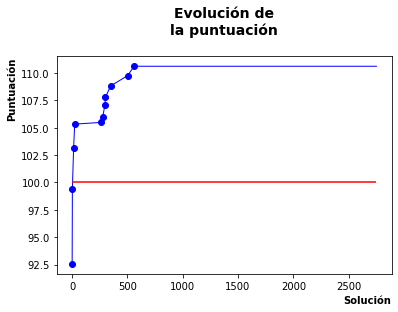

In [ ]:
plt.title('Evolución de\nla puntuación\n', fontsize=14, fontweight ='bold')

plt.plot(id_puntuacion_max, puntuacion_max, color='b', linewidth=1.0, label='Puntuación de la solución')
plt.scatter(id_puntuacion_max[0:-1], puntuacion_max[:-1], color='b', linewidth=1.0)
plt.xlabel("Solución", fontweight ='bold', loc='right')
plt.ylabel("Puntuación", fontweight ='bold', loc='top')
plt.hlines(sol_base['puntuacion'], color='r', xmin=0, xmax=max(id_puntuacion_max))

plt.show()

Valores de la gráfica, tabulados

In [ ]:
for i in range(len(puntuacion_max)):
    print(f'{int(id_puntuacion_max[i]):5d}   -   {puntuacion_max[i]:7.3f} puntos   -   {min(100, 100 * (puntuacion_max[i] - puntuacion_max[max(0, i- 1)]) / puntuacion_max[max(0, i- 1)]):7.3f} %')

    1   -    92.560 puntos   -     0.000 %
    3   -    99.391 puntos   -     7.380 %
   14   -   103.127 puntos   -     3.758 %
   24   -   105.331 puntos   -     2.138 %
  260   -   105.489 puntos   -     0.149 %
  278   -   106.004 puntos   -     0.489 %
  297   -   107.091 puntos   -     1.025 %
  302   -   107.784 puntos   -     0.647 %
  349   -   108.823 puntos   -     0.965 %
  503   -   109.764 puntos   -     0.865 %
  560   -   110.620 puntos   -     0.780 %
 2751   -   110.620 puntos   -     0.000 %


#### Datos varios

Algunos datos estadísticos

In [ ]:
print("Maximo en iteracion = ", max(id_puntuacion_max[0:-1]))
print("Puntuacion minima   = ", min(puntuacion_max[:-1]))
print("Puntuacion media    = ", sum(puntuacion_max[:-1]) / len(puntuacion_max[:-1]))
print("Puntuacion mediana  = ", puntuacion_max[int(len(puntuacion_max[:-1])/2.0)])
print("Puntuacion maxima   = ", max(puntuacion_max[:-1]))

Maximo en iteracion =  560
Puntuacion minima   =  92.56015768556166
Puntuacion media    =  105.08952405256947
Puntuacion mediana  =  106.00419685746431
Puntuacion maxima   =  110.62001368004724


Identifcadores de las soluciones, ordenadas por puntuación

In [ ]:
for i in sorted(poblacion, key=lambda pobl:pobl['puntuacion'], reverse=True):
    print(i['id'], end=' ')

560 755 759 616 1075 503 1282 1010 1620 543 2698 349 364 365 486 487 578 1077 442 909 2331 999 886 2286 1168 2253 1433 1261 2214 1866 302 1953 402 617 1841 2598 2196 2519 2750 2374 2177 412 354 561 1140 399 1625 297 299 300 1112 851 2639 2360 702 821 1098 859 1097 1239 1925 2719 628 769 434 2429 542 316 1373 2498 973 703 352 679 362 2557 1223 1011 472 455 1367 1902 605 622 1052 656 278 283 2341 1663 2333 1741 479 1504 1263 2392 2694 970 329 2471 1869 401 594 1151 639 983 2530 361 1241 1805 516 305 1914 2406 855 260 282 2086 2282 2318 1743 368 265 602 762 630 1690 471 1563 403 577 24 1665 356 1192 589 573 595 2016 989 2665 259 925 1844 854 351 292 1276 2206 750 1253 2443 2045 660 565 1055 328 405 2608 1376 1622 978 665 2219 618 443 1141 2434 2013 1850 296 68 1734 1789 830 1704 456 2194 492 1248 1878 632 641 642 2128 2258 1732 307 832 371 1158 710 483 2722 1887 2428 598 285 389 431 1814 2618 1701 2457 1049 1551 333 2442 1580 2012 2062 315 1555 1170 372 1048 1915 2102 1090 1394 396 678 63